# Preprocessing pipeline

The goal of this pipeline is to produce data that is clean enough to be further analyzed in ERP or connectivity analyses. This pipeline is semi-automatic; manual steps are not necessarily required, but it is advised to revisit the cleaned epochs. ICA components have to be selected manually.

## Outline

Suggestions from this [paper](https://www.biorxiv.org/content/10.1101/240044v1.full.pdf)
- apply bandpass filter (0.5 - 45Hz) on continuous data
- create fixed length epochs 
- preliminary bad epoch rejection
- fit ICA on cleaned data segments
- mark components based on visual inspection
- apply ICA on epochs
- run [autoreject](https://www.sciencedirect.com/science/article/abs/pii/S1053811917305013) 
- find and interpolate bad sensors

## References

[1] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, ISSN 1662-453X

[2] Mainak Jas, Denis Engemann, Federico Raimondo, Yousra Bekhti, and Alexandre Gramfort, “Automated rejection and repair of bad trials in MEG/EEG.” In 6th International Workshop on Pattern Recognition in Neuroimaging (PRNI), 2016.

[3] Mainak Jas, Denis Engemann, Yousra Bekhti, Federico Raimondo, and Alexandre Gramfort. 2017. “Autoreject: Automated artifact rejection for MEG and EEG data”. NeuroImage, 159, 417-429.

[4] Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K. M., & Robbins, K. A. (2015). The PREP pipeline: standardized preprocessing for large-scale EEG analysis. Frontiers in neuroinformatics, 9, 16.



## Install package requirements

Can be ignored if requirements are already installed.

In [1]:
!pip install -r ../requirements.txt

## Import packages


```%matplotlib qt``` is the recommended backend for interactive visualization (can be slower); 
switch to ```%matplotlib inline``` for (faster) static plots

In [4]:
import os
from pathlib import Path
from ipyfilechooser import FileChooser

from eeg_preprocessing.preprocessing import *
from eeg_preprocessing.utils.events import get_events_from_raw, create_epochs_from_events
from eeg_preprocessing.utils.io_raw import read_raw

from matplotlib import pyplot as plt
%matplotlib qt

In [3]:
import sys
sys.path.append('..')

## Load raw data

In [5]:
# Set base path to EEG data
base_path = '/Volumes/crnl-memo-hd/TMS_rewiring/Raw_data'

# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
interim_path = os.path.join(base_path, folder_name)

# Use the widget to navigate to the experiment folder path and select an EEG file 
fc = FileChooser(base_path)
fc.filter_pattern = '*.vhdr'

display(fc)

FileChooser(path='/Volumes/crnl-memo-hd/TMS_rewiring/Raw_data', filename='', title='HTML(value='', layout=Layo…

In [6]:
# Load selected file
raw = read_raw(raw_file_path=fc.selected, add_info=True)
print(raw.info)

Extracting parameters from /Volumes/crnl-memo-hd/TMS_rewiring/Raw_data/15_L/Day3/EEG/15_L_Day3.vhdr...
Setting channel info structure...
<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 condition: L
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 fid: 15_L_Day3
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2020-10-28 09:28:19 UTC
 nchan: 64
 num_day: 3
 projs: []
 sfreq: 500.0 Hz
 subject: 15
>


## Event processing

In [7]:
# Extract triggers from raw instance
events = get_events_from_raw(raw)

# Uncomment to show events
events.head(20)

resting_event_names = events.loc[events['event'].str.contains('rs_'), 'event'].tolist()
asrt_event_names = events.loc[events['event'].str.contains('asrt_'), 'event'].tolist()

## Cut raw data and create epochs based on triggers

### Create epochs

- bandpass filter the continuous data (0.5 - 45 Hz)
- create fixed length epochs (1 second)

In [46]:
epochs = create_epochs_from_events(raw=raw, events=events)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 sec)

Not setting metadata
Not setting metadata
4020 matching events found
No baseline correction applied
0 projection items activated
Loading data for 4020 events and 500 original time points ...
0 bad epochs dropped


## Run preprocessing


### 1.1. Preliminary epoch rejection

In [11]:
epochs_faster = prepare_epochs_for_ica(epochs=epochs)

Preliminary epoch rejection: 
Bad by amplitude:
	[  78  131  137  151  314  832  833  856  964  965 1528 1651 2261 2522
 2659 2672 2969 3127 3266 3445 3622 3623 3732 3768 3931 3936 3937 3965
 3995]
Bad by deviation:
	[  41   49   53   54   68   77   78  132  133  136  138  139  141  142
  148  150  151  164  165  171  186  187  189  190  240  305  313  314
  315  316  409  410  626  645  646  832  833  839  840  964  965 1529
 1632 1780 1781 2018 2070 2522 2523 2542 2543 2658 2659 2660 2930 3191
 3513 3514 3589 3622 3623 3624 3785 3826 3827 3830 3844 3845 3873 3874
 3886 3887 3889 3906 3937 3938 3966 3967 3968 3974 3975 3982 4009 4010
 4011 4017 4018]
Bad by variance:
	[  37   78  131  132  137  140  151  171  187  208  304  312  313  314
  803  833  840  856  964  965 1115 1528 1632 1651 1665 1781 1887 1888
 2261 2334 2379 2429 2454 2469 2476 2522 2542 2577 2589 2659 2662 2666
 2672 2685 2758 2840 2841 2883 2893 2948 2969 2996 3057 3127 3156 3265
 3266 3268 3277 3381 3442 3445 3495 35

### 1.2. Run ICA

We run ICA for the resting and ASRT periods together; it will take a few minutes.
The parameters are: 32 ICA components using ["infomax"](https://mne.tools/stable/generated/mne.preprocessing.infomax.html) algorithm. 

When visualizing the components, it is recommended to subset the data (see below).

In [14]:
ica = run_ica(epochs=epochs_faster)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 32 components
 


/Users/weian/venv/eeg-preprocessing/lib/python3.7/site-packages/mne/preprocessing/infomax_.py:192: RuntimeWarning: overflow encountered in exp
  y = 1.0 / (1.0 + np.exp(-u))


Fitting ICA took 216.6s.


Not setting metadata
Not setting metadata
1082 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


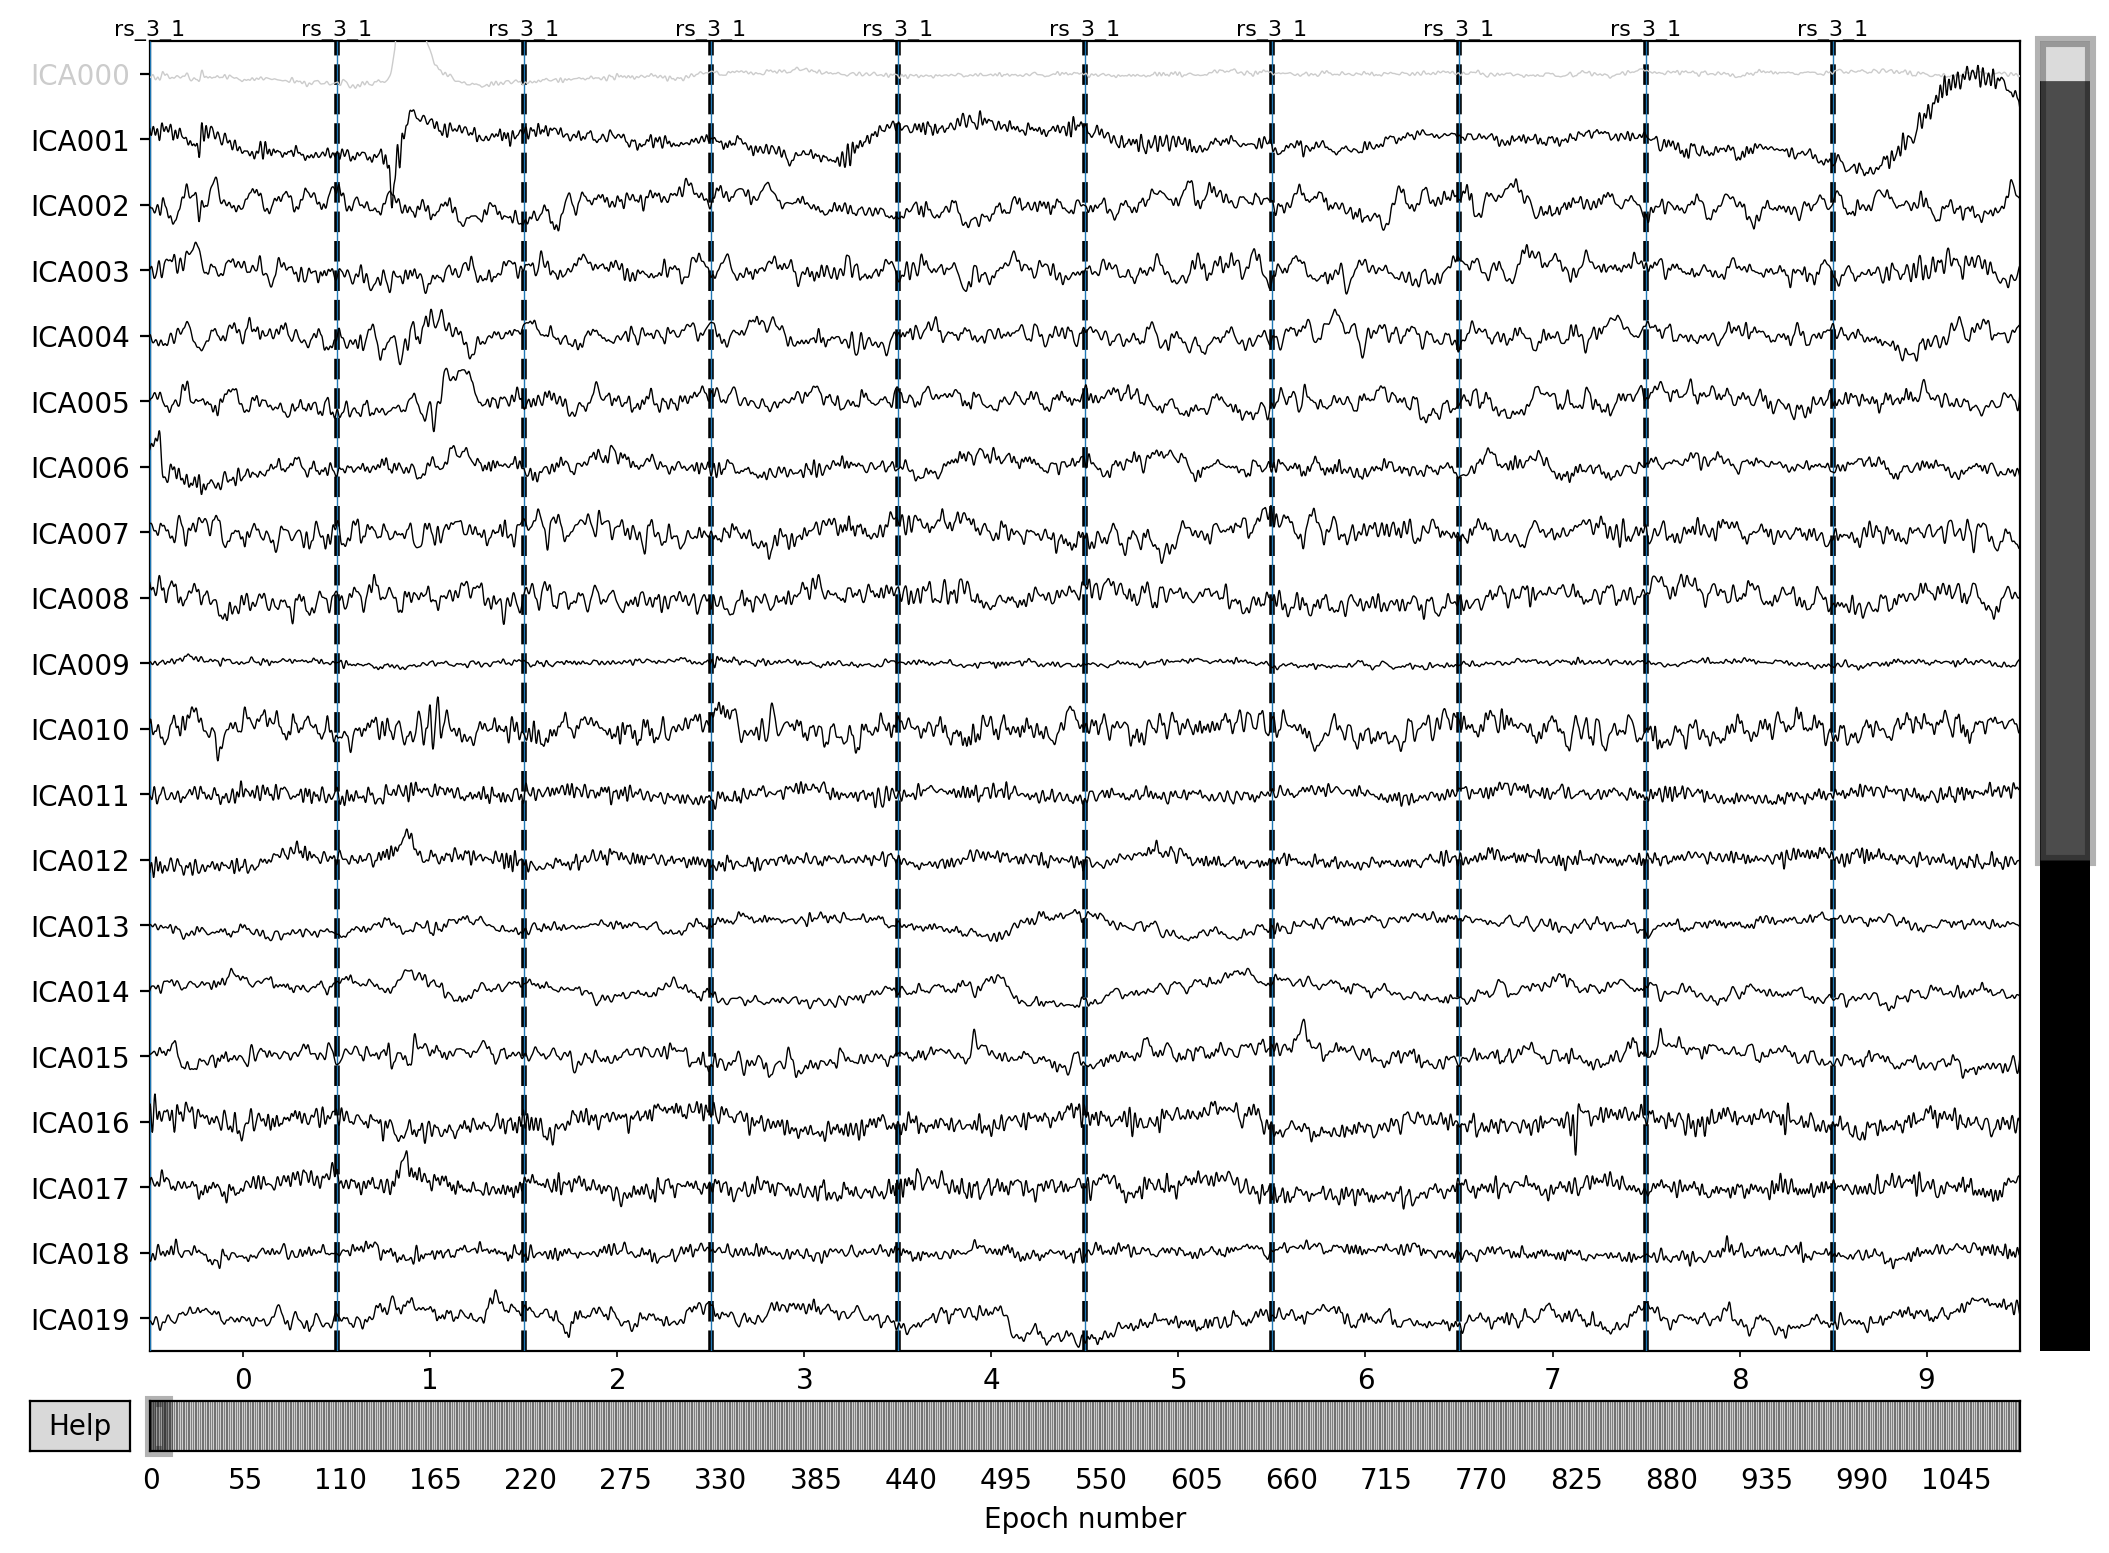

In [16]:
# Visualize components on epochs
# Subset epochs to reduce execution time
subset = resting_event_names + [asrt_event_names[0]]
# Exclude components by selecting them, right click on component name to visulize source:
ica.plot_sources(epochs_faster[subset], start=0, stop=10)

In [17]:
# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_faster)
epochs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


### 1.3. Visualize ICA cleaned epochs (optional)

This step can be repeated after each preprocessing step, or you can also do a final inspection at the end. 

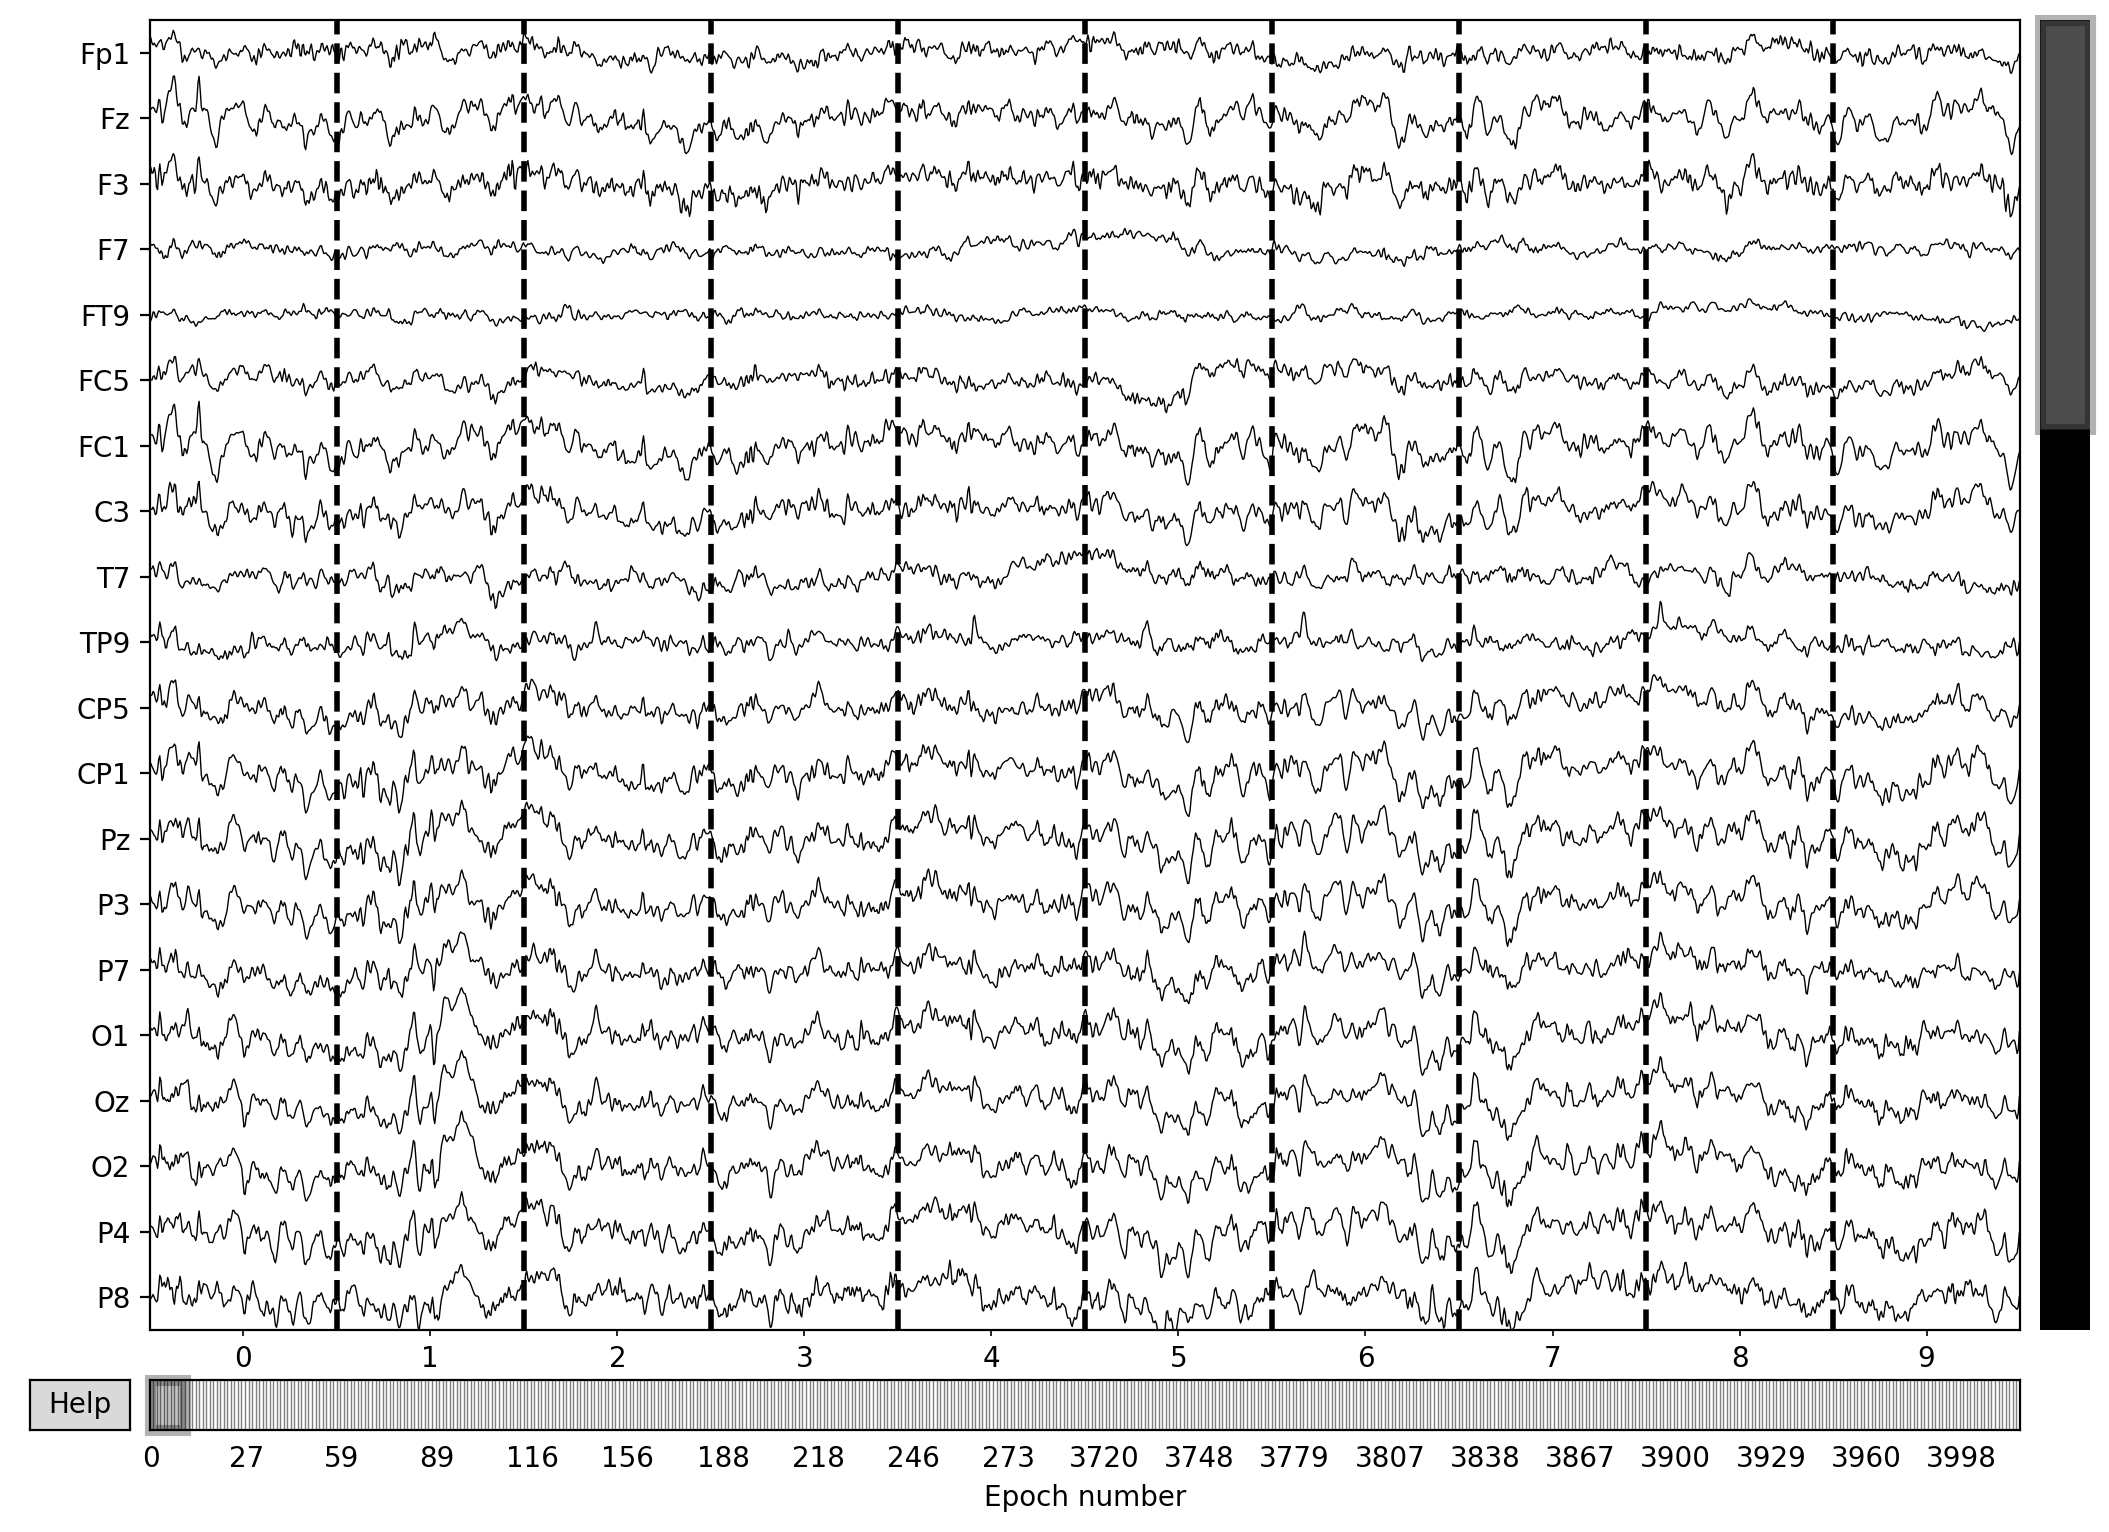

Dropped 0 epochs: 
Channels marked as bad: none


In [19]:
epochs_faster[resting_event_names].plot(n_epochs=10,
                                        scalings={'eeg': 20e-6},
                                        title=raw.info['fid'])

Not setting metadata
Not setting metadata
270 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


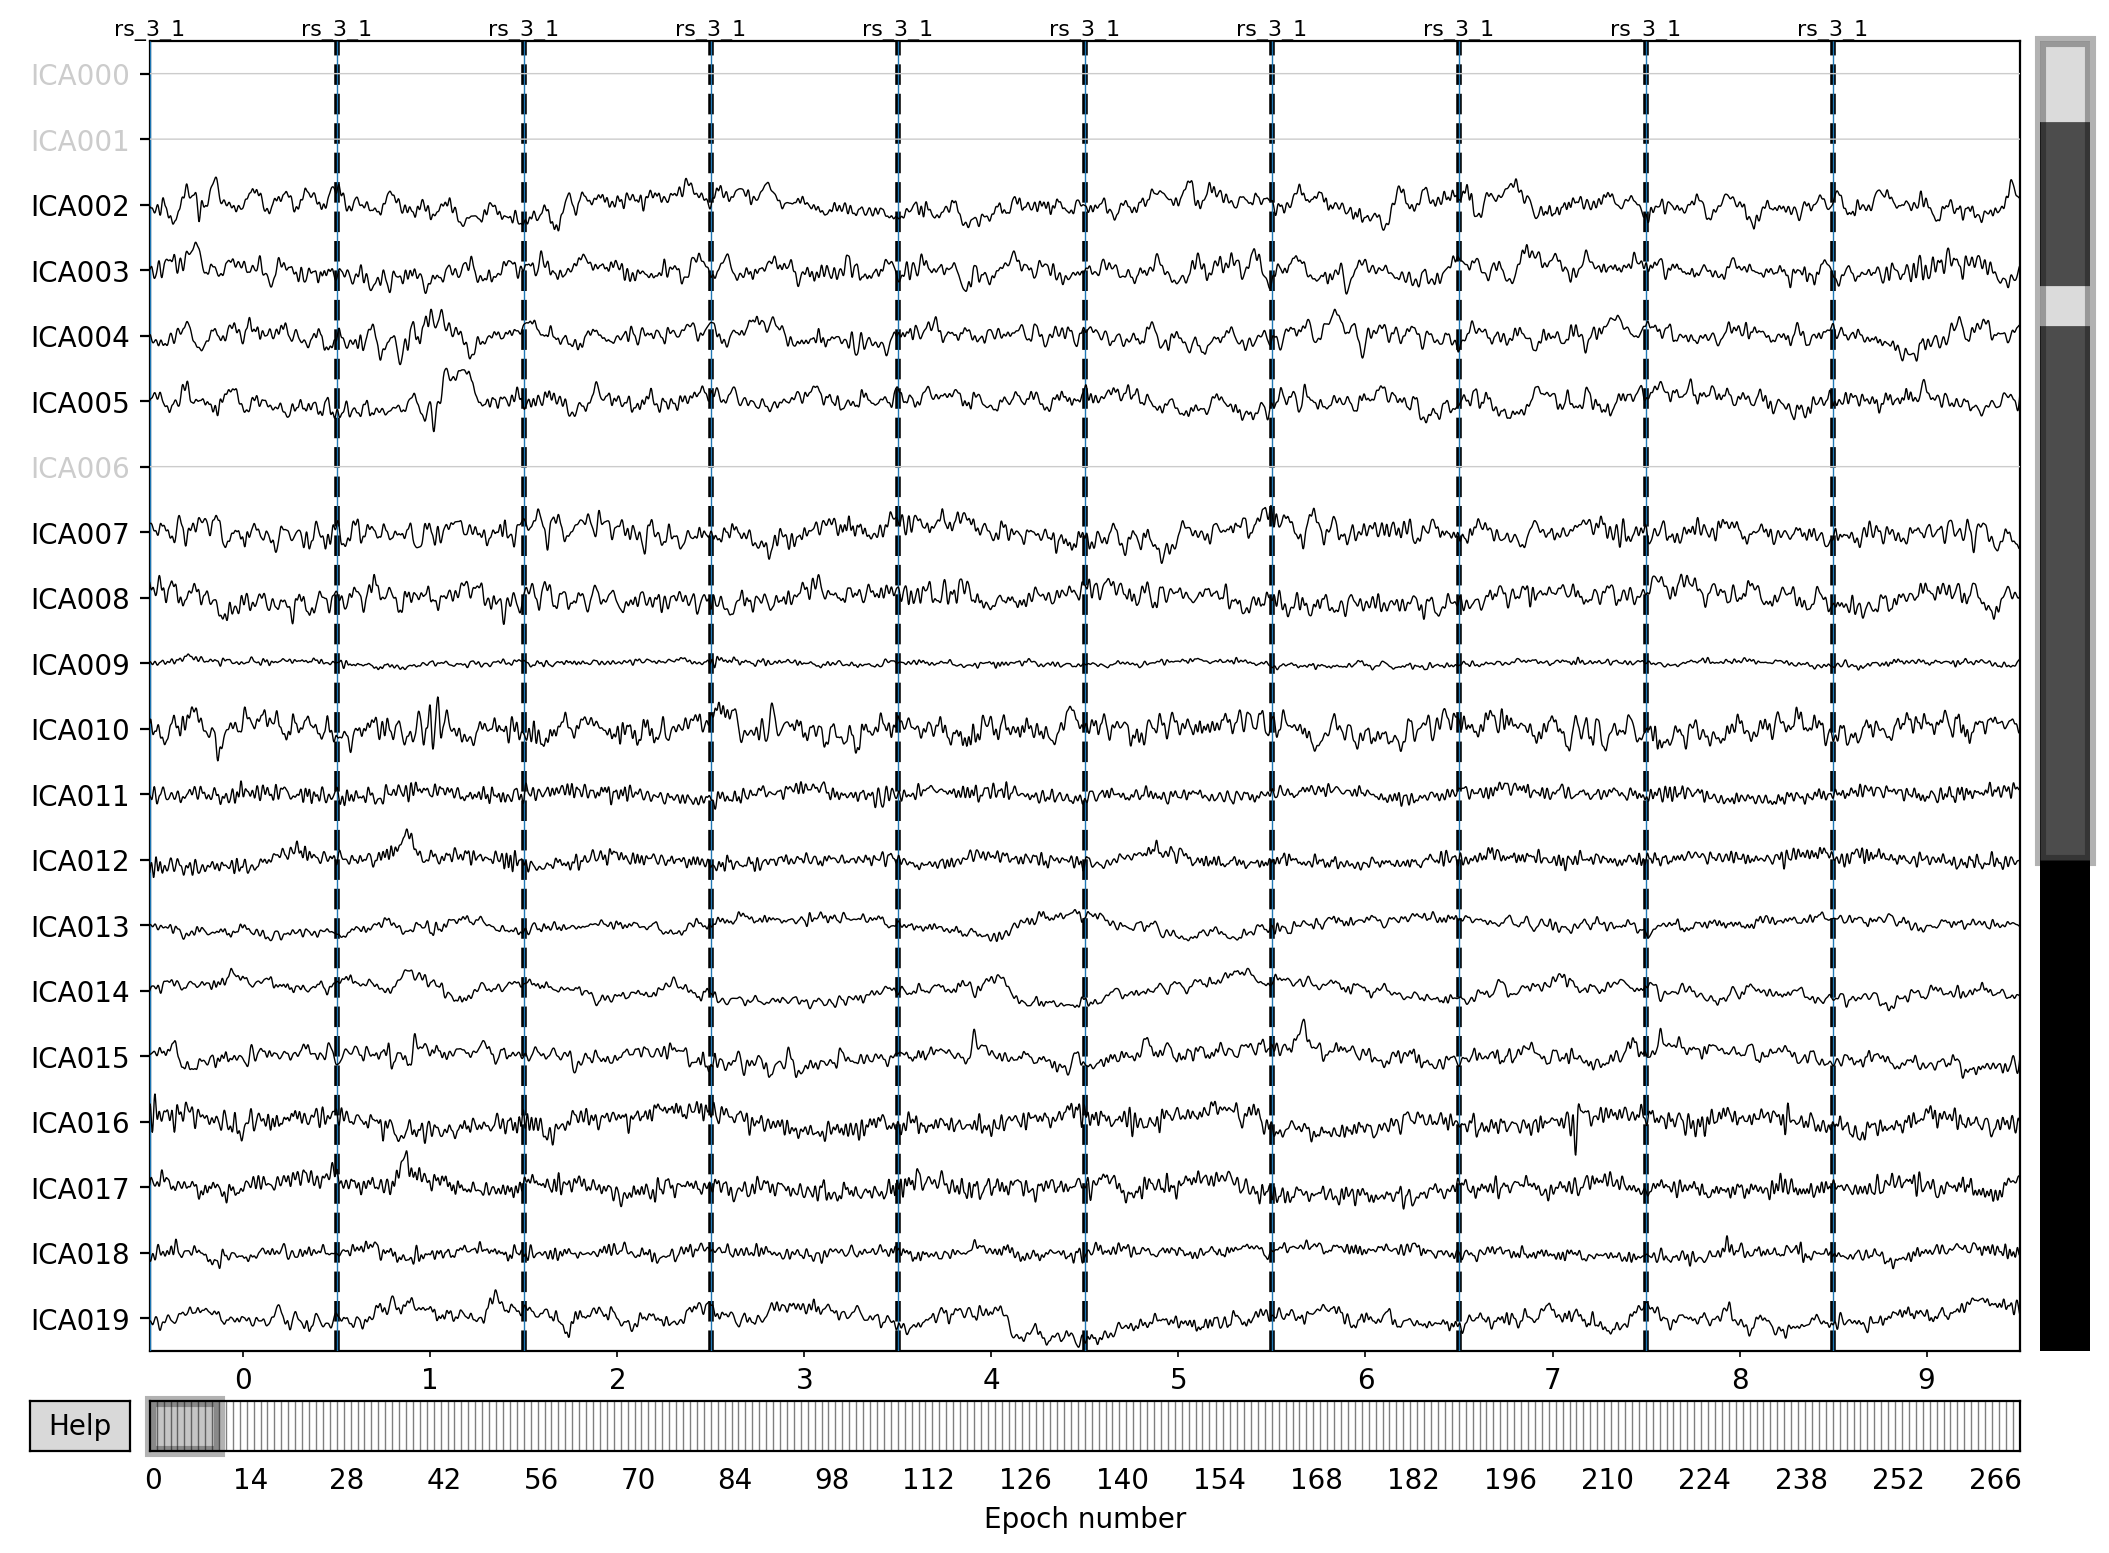

In [20]:
# Optional

# If you found a component that should have been excluded but it wasn't you can exclude it here:
ica.plot_sources(epochs_faster['rs_3_1'], start=0, stop=10)

In [ ]:
# Optional

# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_rs_faster)
epochs_rs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

### 1.4. Save cleaned epochs (recommended)

In [21]:
# Create path to epoch files
interim_epochs_path = os.path.join(interim_path, raw.info['condition'], 'epochs')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Save ICA cleaned epochs 
fid = epochs_faster.info['fid']
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_faster.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

Overwriting existing file.


### 2.1. Run autoreject

In [ ]:
import random
subset = random.sample(set(np.arange(0, n_epochs, 1)), int(n_epochs * 0.25))

In [23]:
ar = run_autoreject(epochs_faster, n_jobs=4, subset=True)

Fitting autoreject on random (n=967) subset of epochs: 
Running autoreject on ch_type=eeg








Estimated consensus=0.60 and n_interpolate=32


In [25]:
# Drop bad epochs (stage 1)

reject_log = ar.get_reject_log(epochs_faster)

epochs_autoreject = epochs_faster.copy().drop(reject_log.bad_epochs, reason='AUTOREJECT')

In [31]:
# Drop bad epochs (stage 2) - after visual inspection
idx = np.where(np.count_nonzero(reject_log.labels, axis=1) > epochs_faster.info['nchan']/2)[0].tolist()

# Plot just the bad epochs!
if idx: 
    epochs_faster[idx].plot(n_epochs=10,
                                scalings={'eeg': 20e-6},
                                n_channels=32)

Dropped 1 epoch: 3483


In [32]:
epochs_autoreject.drop(idx, reason='AUTOREJECT')

Dropped 7 epochs: 606, 1829, 2201, 2817, 2866, 3482, 3483


<Epochs |  3860 events (all good), 0 - 0.998 sec, baseline off, ~942.5 MB, data loaded,
 'asrt_3_1': 551
 'asrt_3_2': 567
 'asrt_3_3': 560
 'asrt_3_4': 555
 'asrt_3_5': 549
 'asrt_3_6': 548
 'rs_3_1': 270
 'rs_3_2': 260>

In [34]:
# save clean epochs
fid = epochs_autoreject.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

### 3. Run ransac

In [35]:
epochs_ransac = run_ransac(epochs_autoreject)

Iterating epochs ...


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:   54.3s remaining:  4.1min
[Parallel(n_jobs=11)]: Done   4 out of  11 | elapsed:   58.6s remaining:  1.7min
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed:  1.0min remaining:   52.1s
[Parallel(n_jobs=11)]: Done   8 out of  11 | elapsed:  1.1min remaining:   24.8s
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:  1.3min finished


[Done]
Interpolating bad channels
    Automatic origin fit: head of radius 85.0 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 6 sensors


In [38]:
# inspect which sensors were interpolated (if any)
epochs_ransac.info

<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 condition: L
 custom_ref_applied: False
 description: n_components: 3, interpolated: TP9, FT10, AF7, FT8, F6, AF8
 dig: 64 items (64 EEG)
 fid: 15_L_Day3
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2020-10-28 09:28:19 UTC
 nchan: 64
 num_day: 3
 projs: []
 sfreq: 500.0 Hz
 subject: 15
>

### 4. Final visual inspection

Mark epochs that should be dropped, select electrodes that should be interpolated etc.

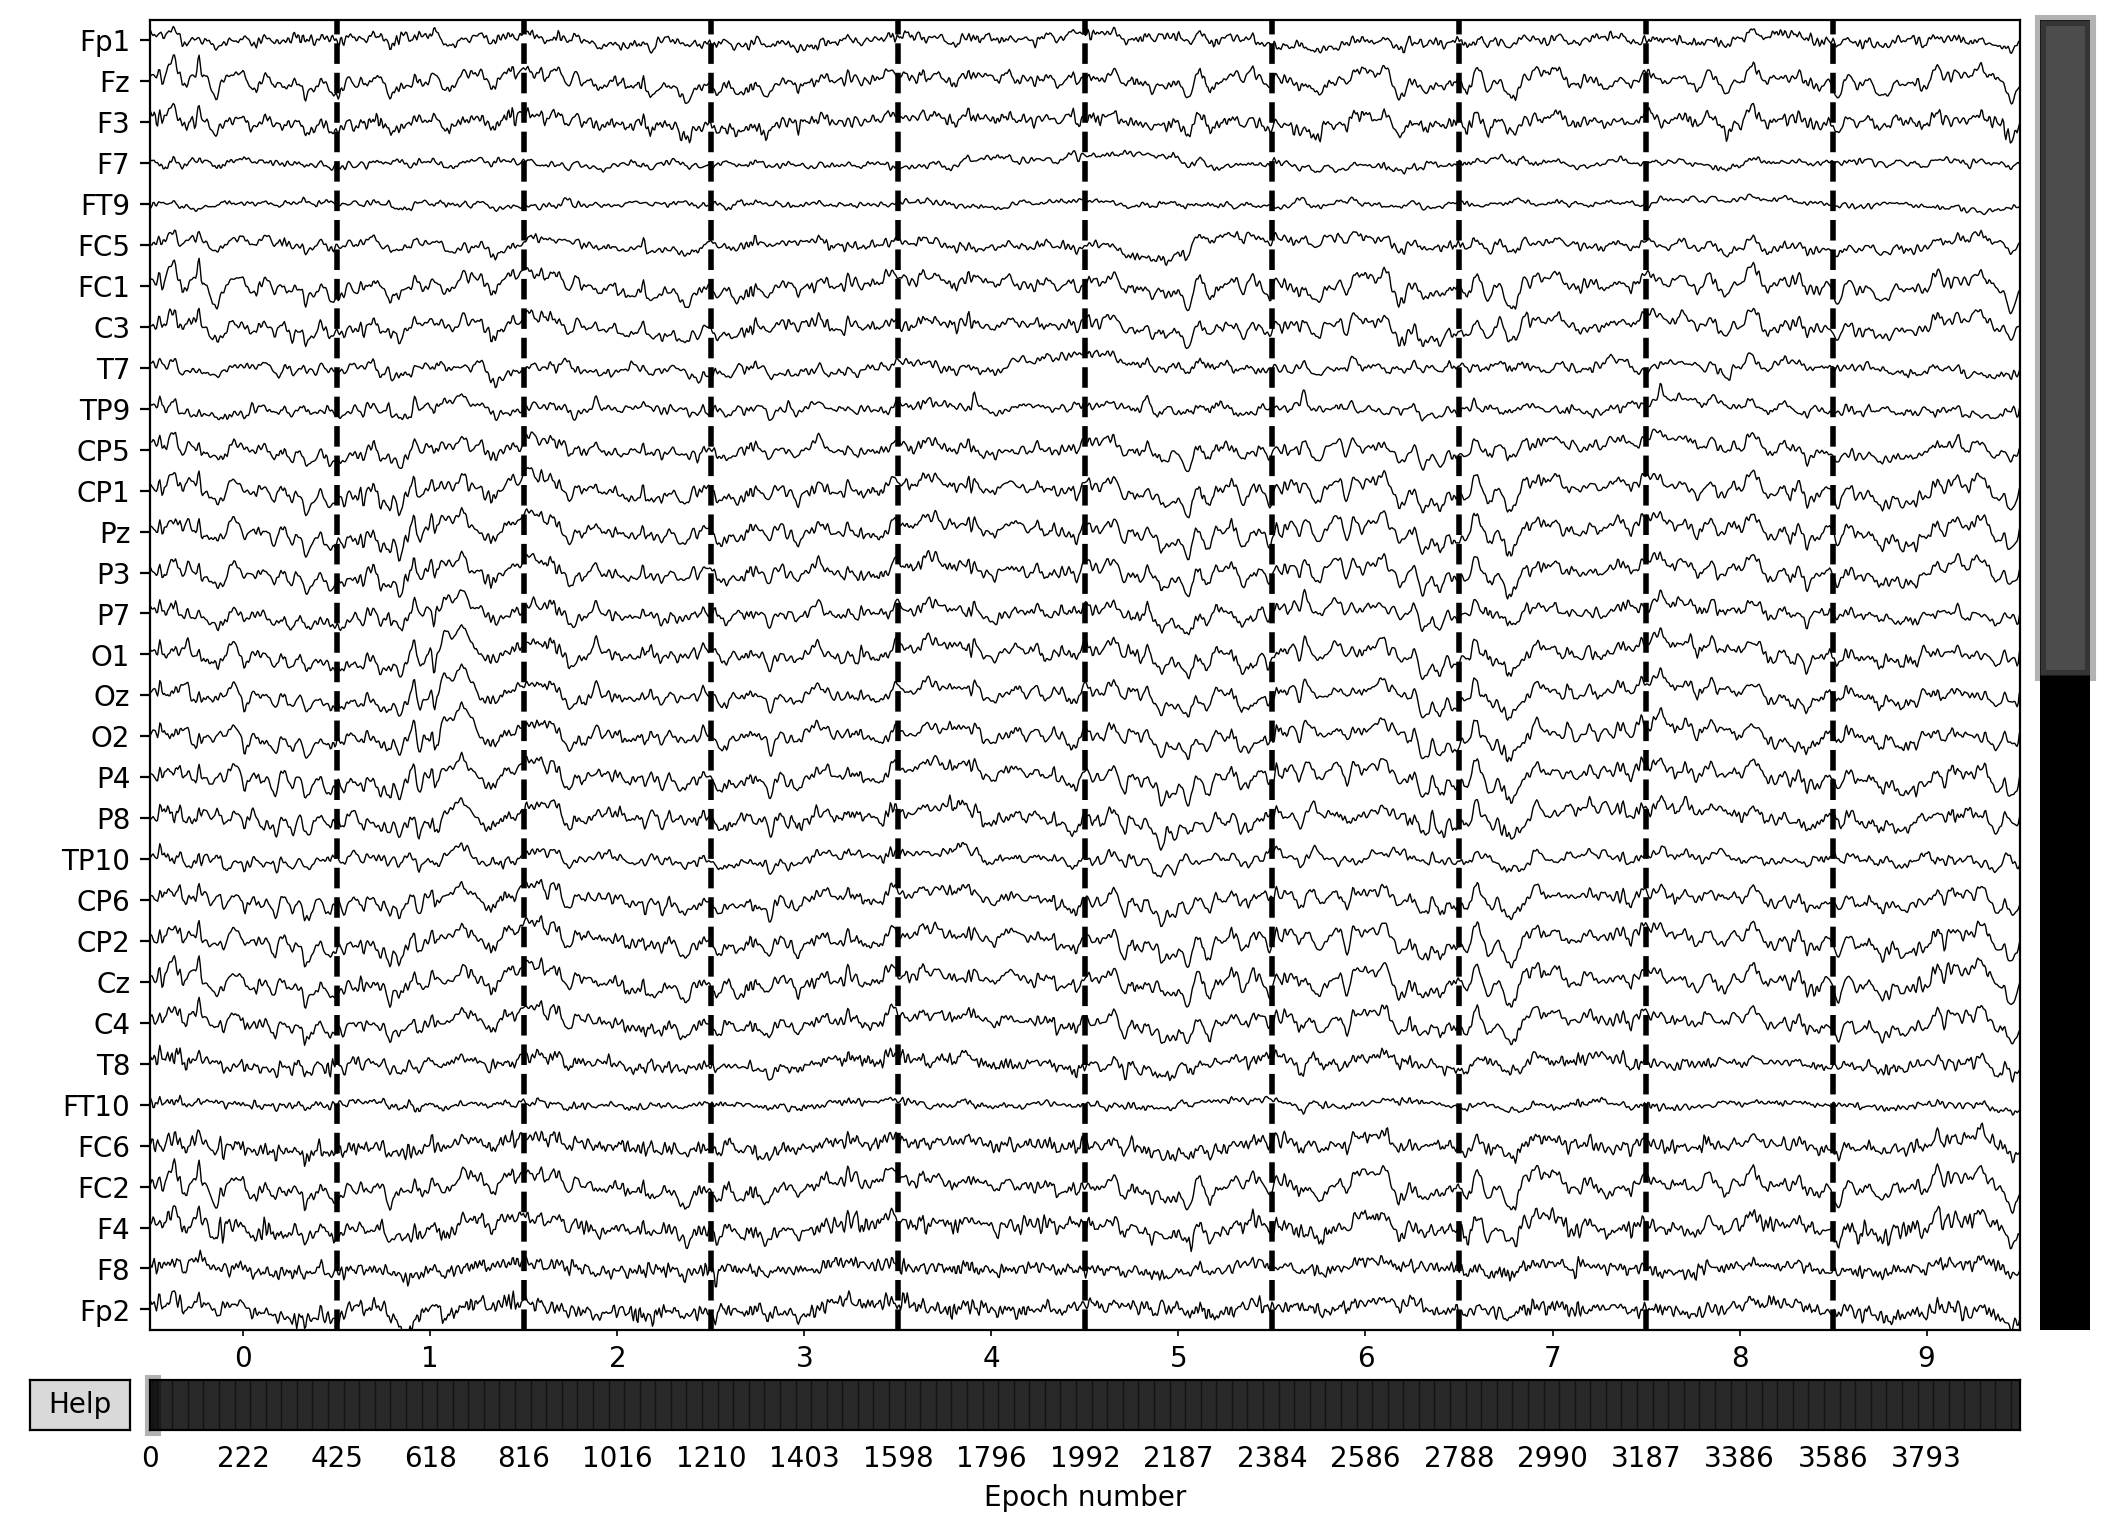

In [ ]:
epochs_ransac.plot(n_epochs=10,
                       n_channels=32,
                       # group_by='position',
                       scalings={'eeg': 20e-6})

In [ ]:
# if there are additional channels marked for interpolation, we can interpolate them here.

if epochs_ransac.info['bads']:
    bads_str = ', '.join(epochs_ransac.info['bads'])
    epochs_ransac.interpolate_bads()
    epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)

### 5. Set average reference

In [42]:
epochs_ransac.set_eeg_reference()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<Epochs |  3860 events (all good), 0 - 0.998 sec, baseline off, ~942.5 MB, data loaded,
 'asrt_3_1': 551
 'asrt_3_2': 567
 'asrt_3_3': 560
 'asrt_3_4': 555
 'asrt_3_5': 549
 'asrt_3_6': 548
 'rs_3_1': 270
 'rs_3_2': 260>

### 6. Annotate continuous data


In [52]:
start_times = [epochs.events[idx][0] / raw.info['sfreq'] 
               for idx, value in enumerate(epochs_ransac.drop_log) if value]

duration = (epochs_ransac.events[1][0] - epochs_ransac.events[0][0]) / raw.info['sfreq'] 

raw.annotations.append(onset=start_times,
                       duration=[duration] * len(start_times),
                       description='BAD_auto')

<Annotations | 8156 segments: BAD_auto (160), New Segment/ (1), Stimulus/S ...>

In [56]:
# Create path to annotated files
annotated_raw_path = os.path.join(interim_path, raw.info['condition'], 'raw')
if not os.path.exists(annotated_raw_path):
    os.makedirs(annotated_raw_path)

# Save annotated continuous data
fid = raw.info["fid"]
raw_annotated_fname = f'{fid}_bad_annotated'
postfix = '-raw.fif.gz'
raw.save(os.path.join(annotated_raw_path, f'{raw_annotated_fname}{postfix}'), overwrite=False)

### 7. Save cleaned epochs

#### 7.1. Resting period before ASRT

In [67]:
# Create path to annotated files
epochs_rs_path = os.path.join(interim_path, raw.info['condition'], 'epochs_rs')
if not os.path.exists(epochs_rs_path):
    os.makedirs(epochs_rs_path)

rs_period_name = f'rs_{raw.info["num_day"]}_1'
fid = f'{raw.info["subject"]}_{raw.info["condition"]}_{rs_period_name}'
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'

epochs_ransac[rs_period_name].save(os.path.join(epochs_rs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

#### 7.2. Resting period before ASRT

In [69]:
rs_period_name = f'rs_{raw.info["num_day"]}_2'
fid = f'{raw.info["subject"]}_{raw.info["condition"]}_{rs_period_name}'
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'

epochs_ransac[rs_period_name].save(os.path.join(epochs_rs_path,
                                                f'{epochs_clean_fname}{postfix}'), overwrite=True)

Overwriting existing file.


#### 7.3. ASRT

In [114]:
# Create path to annotated files
epochs_asrt_path = os.path.join(interim_path, raw.info['condition'], 'epochs_asrt')
if not os.path.exists(epochs_asrt_path):
    os.makedirs(epochs_asrt_path)

In [115]:
for sequence, periods in events.groupby('sequence')['event'].apply(set).to_dict().items():
    #epochs_to_merge = [epochs_ransac[period] for period in periods]
    #merged_epochs = mne.concatenate_epochs(epochs_to_merge, offset=True)
    fid = f'{raw.info["subject"]}_{raw.info["condition"]}_asrt_{raw.info["num_day"]}_{sequence}'
    epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
    postfix = '-epo.fif.gz'
    
    epochs_ransac[sorted(set(periods))].save(os.path.join(epochs_asrt_path,
                                                          f'{epochs_clean_fname}{postfix}'), overwrite=True)

['asrt_3_1', 'asrt_3_3', 'asrt_3_5']
['asrt_3_2', 'asrt_3_4', 'asrt_3_6']


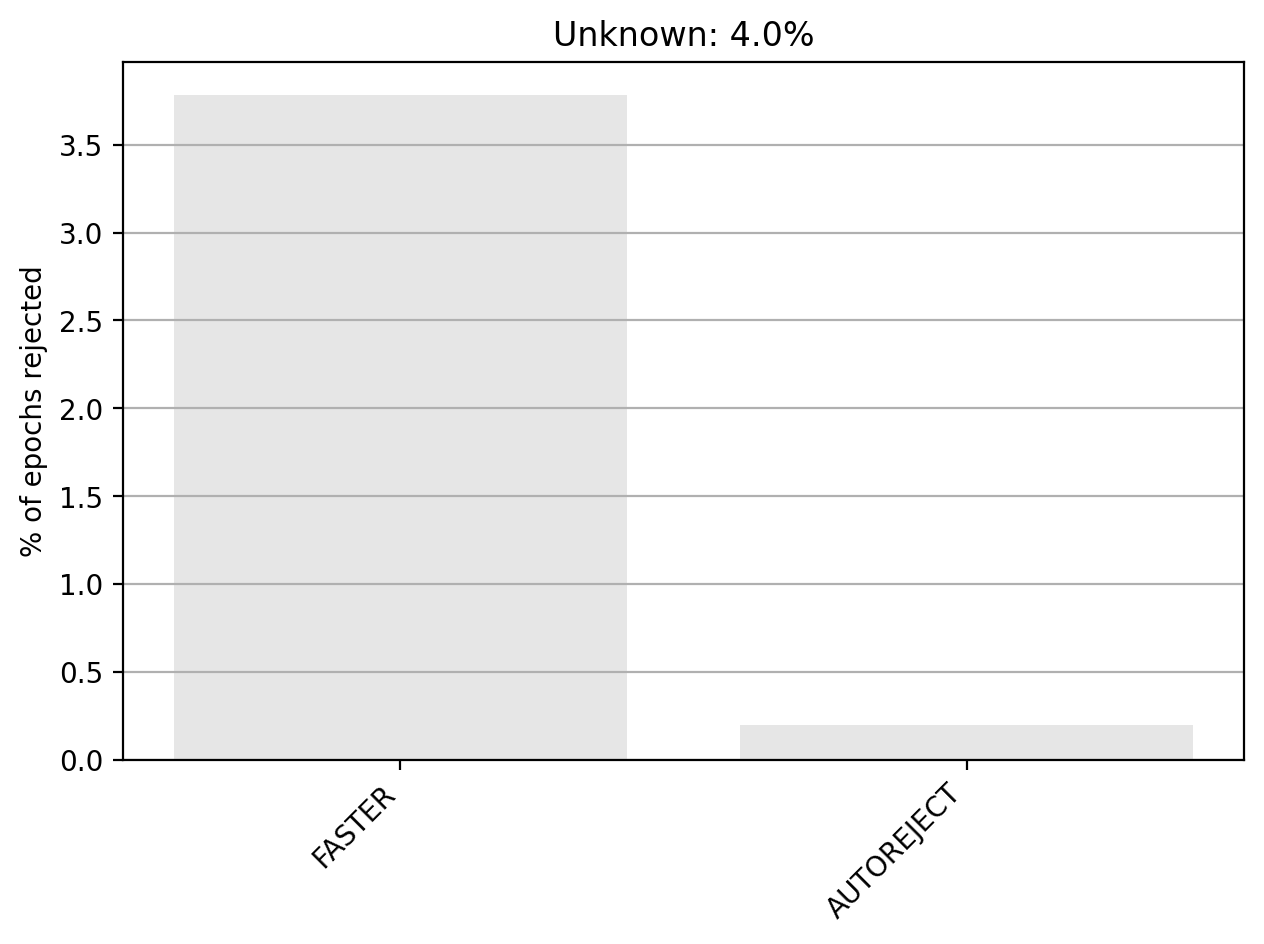

Dropped 0 epochs: 
Channels marked as bad: none


In [116]:
epochs_ransac.plot_drop_log()

In [117]:
# cleanup from memory
del raw, epochs, epochs_autoreject, epochs_ransac

plt.close('all')